## Load and apply inference models
This notebook loads trained inference models from the outputs of `cmass.infer.train`, plots their prediction performance, and applies them to new test data.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import pickle
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../../style.mcstyle')   # noqa
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


## Cut up abacus simulations
See old qui_infers_aba.ipynb

## Examine abacus cosmologies

In [3]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
tabpath = join(wdir, 'scratch', 'abacus_custom_table.csv')
cosm = pd.read_csv(tabpath)

Omega_m = cosm['omega_cdm'] + cosm['omega_b'] + cosm['omega_ncdm']
Omega_b = cosm['omega_b']
h = cosm['h']
n_s = cosm['n_s']
sigma8 = cosm['sigma8_m']

# rescale to capital Omega
Omega_m /= h**2
Omega_b /= h**2

idx_lcdm = np.argwhere(cosm['LCDM'] == 'y').flatten().tolist()
idx_mnu = np.argwhere(cosm['Massive Neutrinos'] == 'y').flatten().tolist()
idx_simple = list(set(idx_lcdm) - set(idx_mnu))

print('LCDM:', idx_lcdm)
print('Mnu>0:', idx_mnu)
print('LCDM & Mnu=0:', idx_simple)

cosm

LCDM: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 53, 54, 55, 56, 57, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]
Mnu>0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]
LCDM & Mnu=0: [32, 34, 35, 36, 37, 38, 40, 30, 31]


,LHID,Cosmology,Phase,LCDM,Massive Neutrinos,SimName,Description,omega_b,omega_cdm,h,A_s,n_s,alpha_s,N_ur,N_ncdm,omega_ncdm,w0_fld,wa_fld,sigma8_m,sigma8_cb
0,0,0,0,y,y,AbacusSummit_base_c000_ph000,Planck2018 LCDM,0.049302,0.1200,0.6736,2.080000e-09,0.9649,0.000,2.0328,1,0.000644,-1.000,0.000,0.807952,0.811355
1,1,0,1,y,y,AbacusSummit_base_c000_ph001,Planck2018 LCDM,0.049302,0.1200,0.6736,2.080000e-09,0.9649,0.000,2.0328,1,0.000644,-1.000,0.000,0.807952,0.811355
2,2,0,2,y,y,AbacusSummit_base_c000_ph002,Planck2018 LCDM,0.049302,0.1200,0.6736,2.080000e-09,0.9649,0.000,2.0328,1,0.000644,-1.000,0.000,0.807952,0.811355
3,3,0,3,y,y,AbacusSummit_base_c000_ph003,Planck2018 LCDM,0.049302,0.1200,0.6736,2.080000e-09,0.9649,0.000,2.0328,1,0.000644,-1.000,0.000,0.807952,0.811355
4,4,0,4,y,y,AbacusSummit_base_c000_ph004,Planck2018 LCDM,0.049302,0.1200,0.6736,2.080000e-09,0.9649,0.000,2.0328,1,0.000644,-1.000,0.000,0.807952,0.811355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,114,176,0,n,y,AbacusSummit_base_c176_ph000,Broader Emulator Grid,0.046041,0.1199,0.6972,2.310000e-09,0.9459,0.036,1.9043,1,0.000644,-1.222,0.339,0.892483,0.896318
115,115,177,0,n,y,AbacusSummit_base_c177_ph000,Broader Emulator Grid,0.048138,0.1344,0.6820,2.060000e-09,1.0002,0.007,2.8643,1,0.000644,-0.757,-0.443,0.806026,0.809110
116,116,178,0,n,y,AbacusSummit_base_c178_ph000,Broader Emulator Grid,0.052199,0.1204,0.6542,1.970000e-09,0.9424,0.037,1.8987,1,0.000644,-0.874,-0.455,0.791239,0.794555
117,117,179,0,n,y,AbacusSummit_base_c179_ph000,Broader Emulator Grid,0.064766,0.1067,0.5881,2.240000e-09,0.9308,-0.003,1.1884,1,0.000644,-0.755,-0.435,0.775969,0.779541


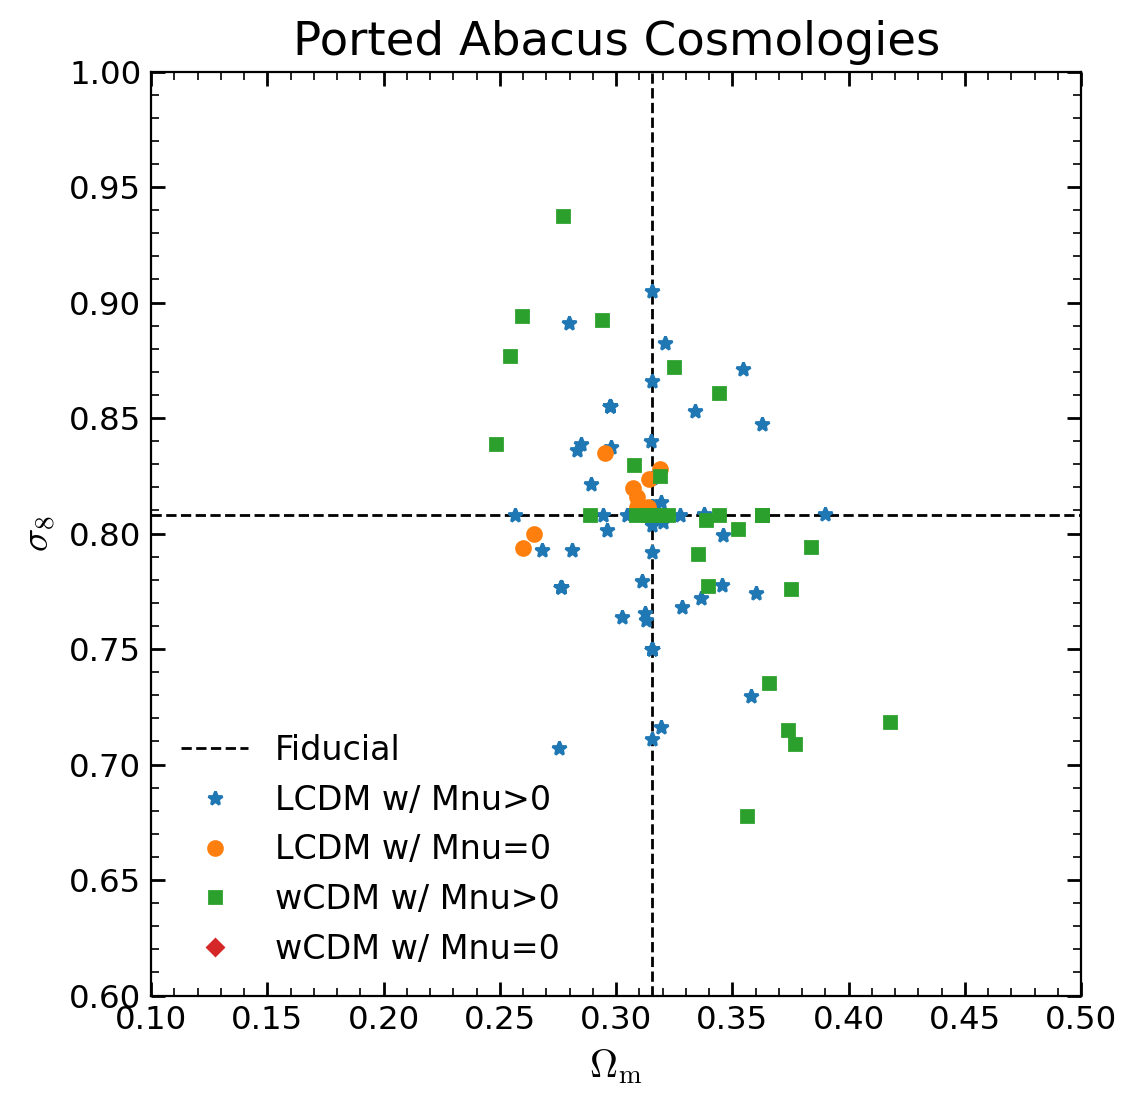

In [4]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))

x, y = Omega_m, sigma8

# LCDM
m = cosm['LCDM'] == 'y'
n = cosm['Massive Neutrinos'] == 'y'
ax.axvline(x[0], color='k', linestyle='--', lw=1)
ax.axhline(y[0], color='k', linestyle='--', lw=1, label='Fiducial')
ax.plot(x[m & n], y[m & n], '*', markersize=5,
        color='C0', label='LCDM w/ Mnu>0')
ax.plot(x[m & ~n], y[m & ~n], 'o', markersize=5,
        color='C1', label='LCDM w/ Mnu=0')
ax.plot(x[~m & n], y[~m & n], 's', markersize=4,
        color='C2', label='wCDM w/ Mnu>0')
ax.plot(x[~m & ~n], y[~m & ~n], 'D', markersize=4,
        color='C3', label='wCDM w/ Mnu=0')

ax.set(xlabel=r'$\Omega_{\rm m}$', ylabel=r'$\sigma_8$',
       title='Ported Abacus Cosmologies')
ax.set_xlim(0.1, 0.5)
ax.set_ylim(0.6, 1.0)
ax.legend(loc='lower left', fontsize=12, frameon=False)

## Load a model

In [18]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']
names = cosmonames  # +hodnames

# Specify model configuration
nbody = 'quijote'
sim = 'nbody'
save_dir = join(wdir, nbody, sim, 'models')

# Specify data dtype
tracer = 'halo'
# tracer = 'galaxy'
summaries = ['zPk0', 'zPk2', 'zPk4',  'zQk0']
# summaries = ['Pk0', 'Pk2', 'Pk4', 'Qk0']
summary = '+'.join(summaries)
kmin, kmax = 0.0, 0.1
modelpath = join(save_dir, tracer, summary, f'kmin-{kmin}_kmax-{kmax}')
os.listdir(modelpath)

['x_val.npy',
 'posterior.pkl',
 'true_logprobs.npy',
 'ids_test.npy',
 'theta_train.npy',
 'plot_coverage.jpg',
 'theta_test.npy',
 'x_test.npy',
 'nets',
 'plot_true_logprobs.jpg',
 'ids_train.npy',
 'theta_val.npy',
 'ranks_histogram.jpg',
 'plot_single_posterior.jpg',
 'x_train.npy',
 'plot_TARP.jpg',
 'plot_predictions.jpg',
 'ids_val.npy',
 'posterior_samples.npy']

In [19]:
# Load predictions
xtest = np.load(join(modelpath, 'x_test.npy'))
ytest = np.load(join(modelpath, 'theta_test.npy'))
samps = np.load(join(modelpath, 'posterior_samples.npy'))
percs = np.percentile(samps, [16, 50, 84], axis=0)

yrange = np.stack([
    ytest.min(axis=0),
    ytest.max(axis=0)
], axis=1)

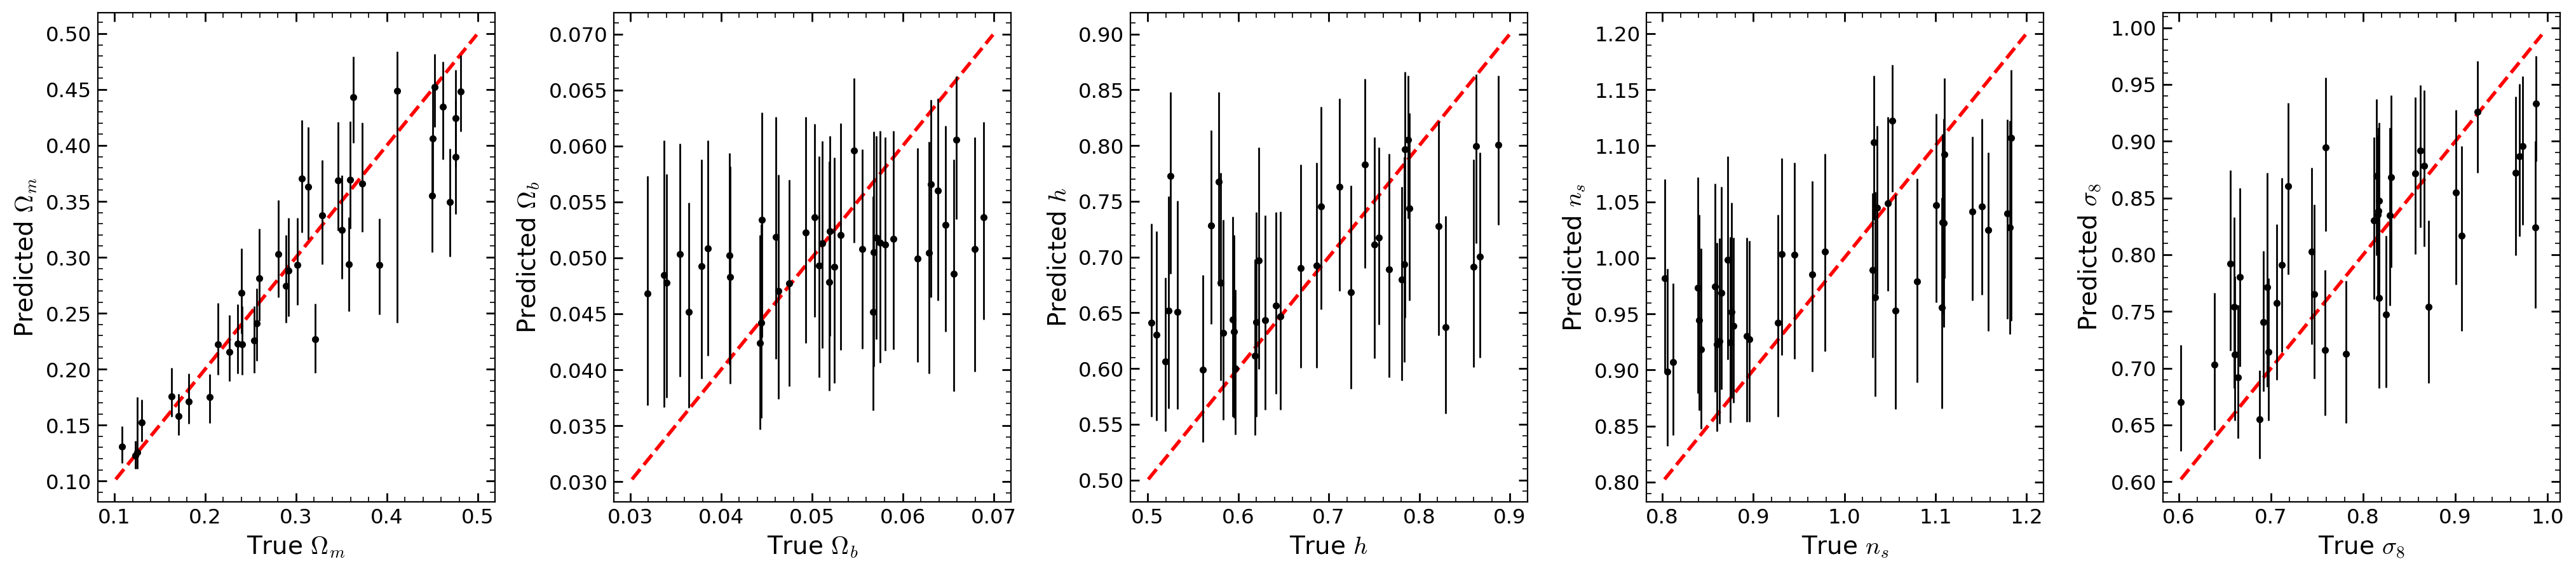

In [20]:
ss = 5

N = len(names)
H, W = N//5, 5
f, axs = plt.subplots(H, W, figsize=(5*W, 5*H), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i >= N:
        ax.axis('off')
        continue
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.plot(ytest[::ss, i], percs[1, ::ss, i], 'k.')
    ax.errorbar(ytest[::ss, i], percs[1, ::ss, i], yerr=[percs[1, ::ss, i]-percs[0, ::ss, i],
                percs[2, ::ss, i]-percs[1, ::ss, i]], fmt='none', ecolor='k', elinewidth=1)
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')

In [21]:
# these functions load pickled torch modules
# if the model was trained on GPU, this will ensure safe loading to CPU
# TODO: update ltu-ili so this is already handled...

import torch
import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


def load_posterior(modeldir):
    with open(join(modeldir, 'posterior.pkl'), 'rb') as f:
        ensemble = CPU_Unpickler(f).load()
    ensemble = ensemble.to(device)
    for p in ensemble.posteriors:
        p.to(device)
    return ensemble


posterior = load_posterior(modelpath)
for p in posterior.posteriors:
    print(type(p.nde.flow))

<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>
<class 'zuko.flows.autoregressive.MAF'>


100%|██████████| 40/40 [00:00<00:00, 392.80it/s]


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Log Probability')]

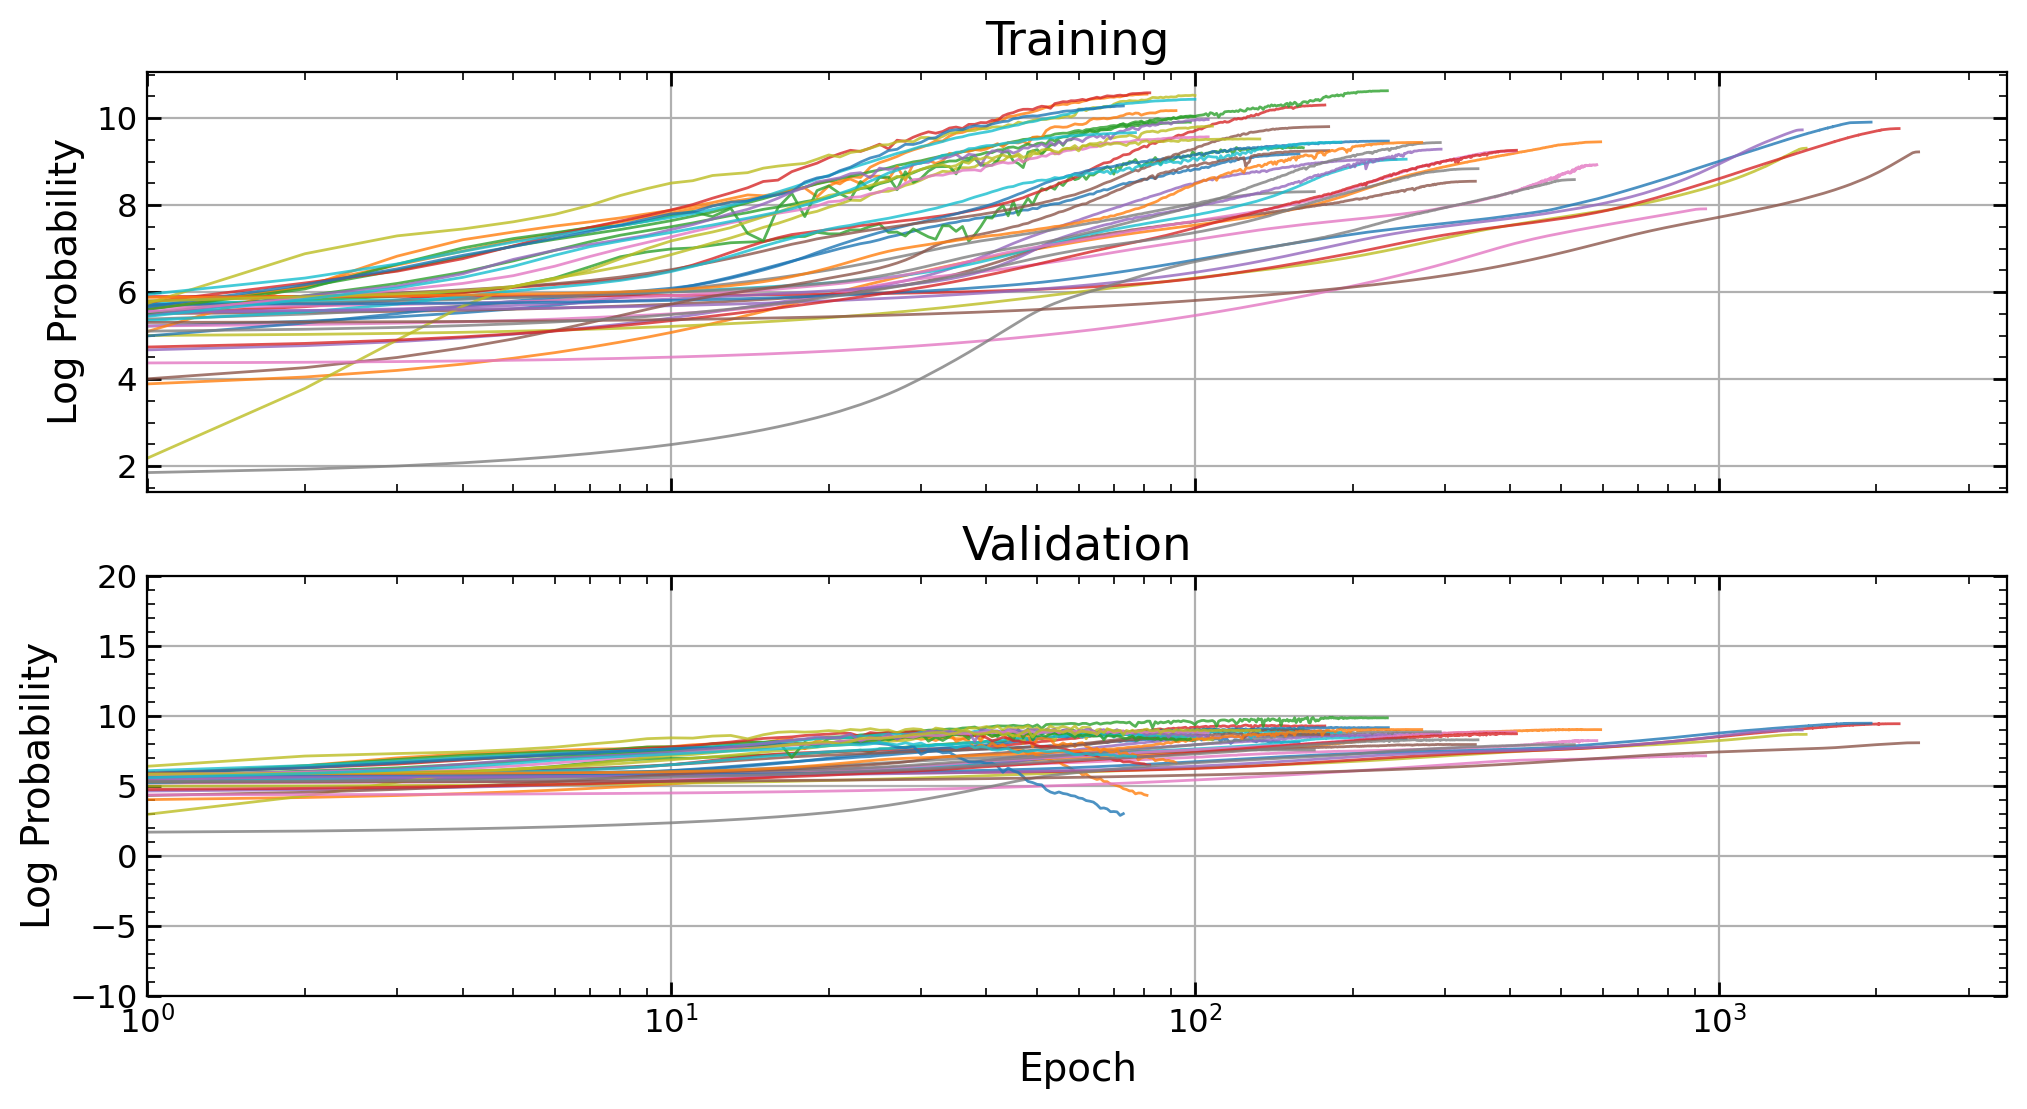

In [22]:
ss = 5

netpath = join(modelpath, 'nets')
netlist = os.listdir(netpath)

f, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for n in tqdm(netlist[::ss]):
    filepath = join(netpath, n, 'summary.json')
    if not os.path.exists(filepath):
        continue
    with open(filepath, 'r') as f:
        history = json.load(f)

    x_ = range(1, len(history[0]['training_log_probs'])+1)

    ax = axs[0]
    ax.plot(x_, history[0]['training_log_probs'], alpha=0.8, lw=1)

    ax = axs[1]
    ax.plot(x_, history[0]['validation_log_probs'], alpha=0.8, lw=1)

ax.semilogx()
ax.set_xlim(1)
ax.set_ylim(-10, 20)

axs[0].set_title('Training')
axs[1].set_title('Validation')
axs[0].grid()
axs[1].grid()

axs[0].set(ylabel='Log Probability')
axs[1].set(xlabel='Epoch', ylabel='Log Probability')

INFO:root:Sampling models with [324, 212, 207, 194, 191, 180, 179, 177, 172, 168] samples each.
Drawing 324 posterior samples: 449it [00:00, 603.03it/s]                         
Drawing 212 posterior samples: 292it [00:02, 130.13it/s]                         
Drawing 207 posterior samples: 306it [00:01, 203.47it/s]                         
Drawing 194 posterior samples: 247it [00:00, 330.95it/s]                         
Drawing 191 posterior samples: 298it [00:00, 393.83it/s]                         
Drawing 180 posterior samples: 247it [00:00, 2425.17it/s]             
Drawing 179 posterior samples: 252it [00:00, 13362.89it/s]            
Drawing 177 posterior samples: 284it [00:00, 32659.29it/s]            
Drawing 172 posterior samples: 273it [00:00, 32015.80it/s]            
Drawing 168 posterior samples: 226it [00:00, 12268.01it/s]            


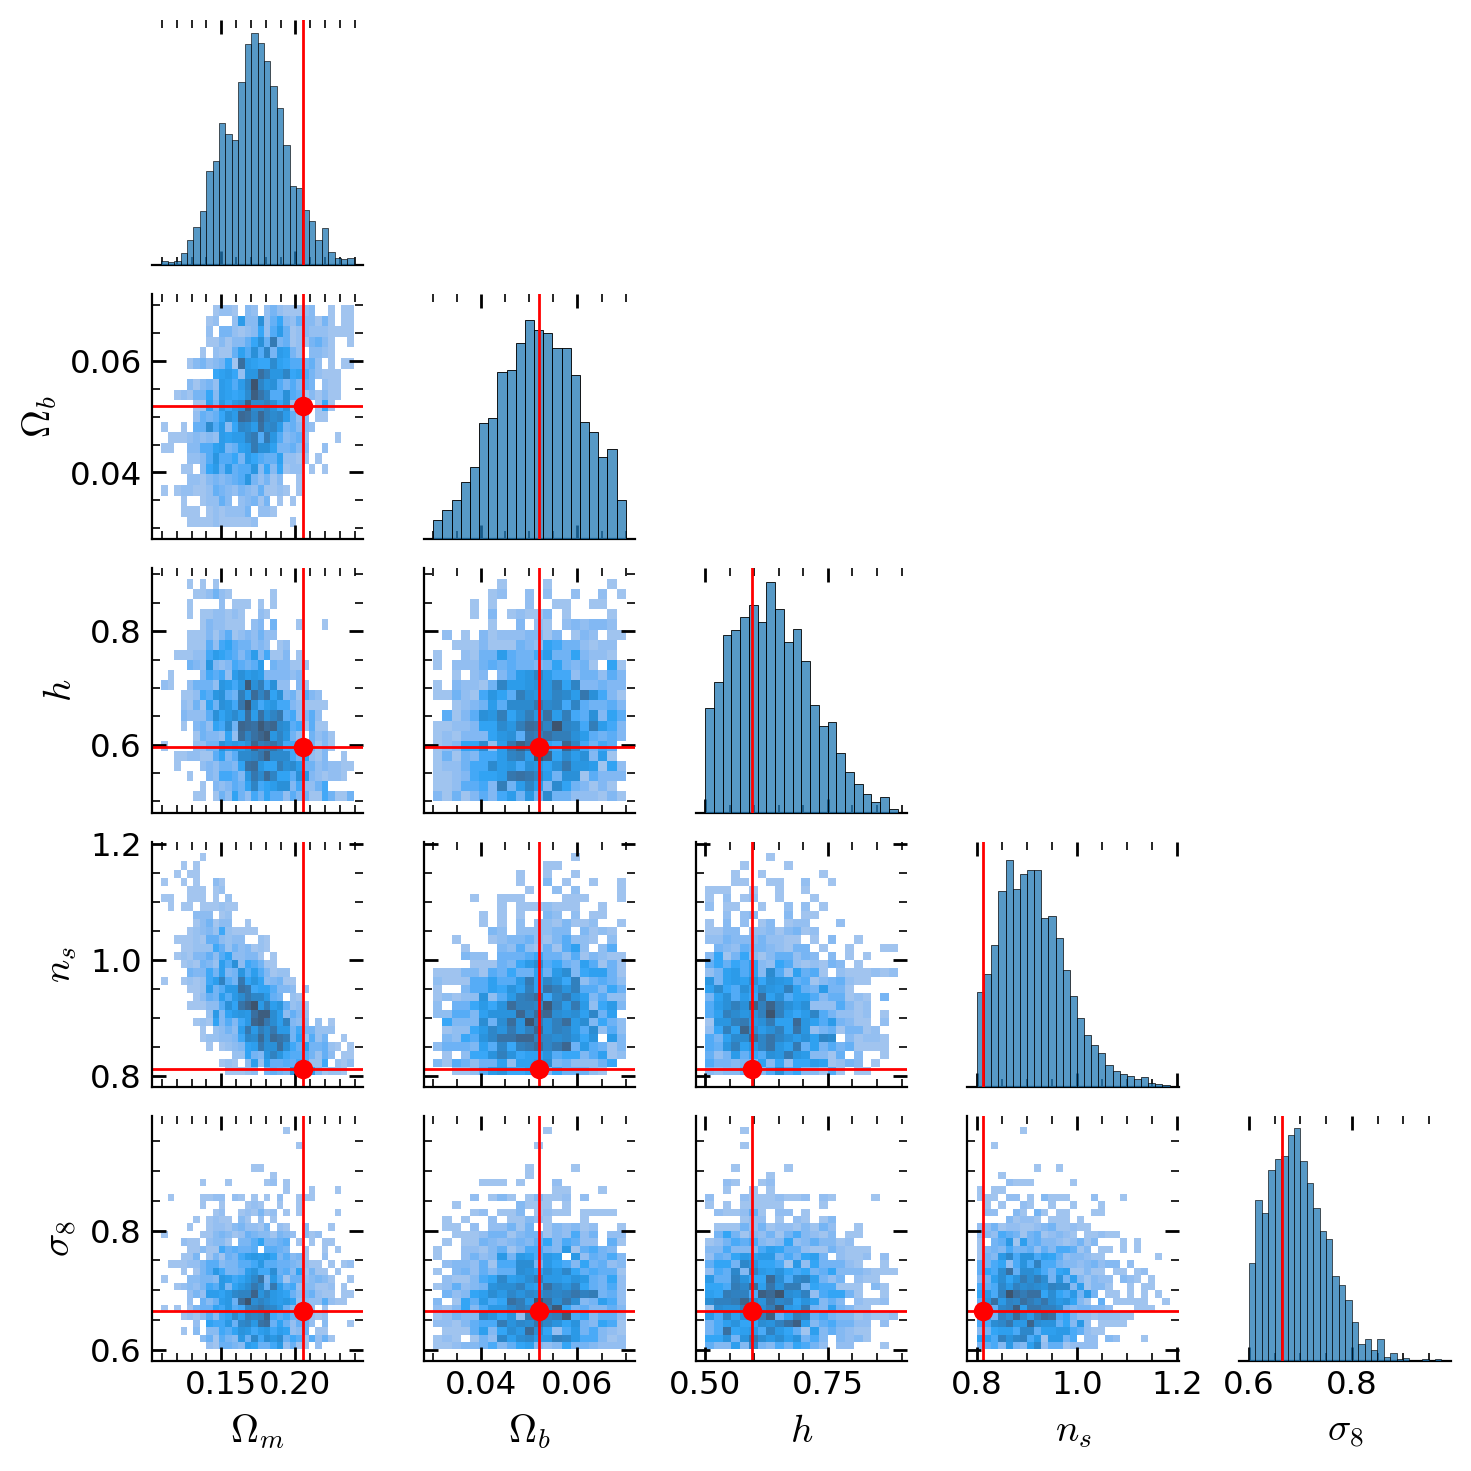

In [23]:
# Predict on a random test point
ind = 15
x0 = torch.Tensor(xtest[ind]).to(device)
y0 = ytest[ind]
samp0 = posterior.sample(x=x0, shape=(2000,))
samp0 = pd.DataFrame(samp0, columns=names)


def plot_true_vals(grid, true_vals, **kwargs):
    for i, val in enumerate(true_vals):
        grid.diag_axes[i].axvline(val, **kwargs)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.axvline(true_vals[j], **kwargs)
                ax.axhline(val, **kwargs)
                ax.plot(true_vals[j], val, 'o', **kwargs)


g = sns.pairplot(
    samp0,
    vars=names,
    kind='hist',
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)

plot_true_vals(g, y0, color='r', lw=1)

## Load an observed summary

In [24]:
# Load observed data
nbody = 'abacus1gpch'
sim = 'custom'
save_dir = join(wdir, nbody, sim, 'models')
modelpath = join(save_dir, tracer, summary, f'kmin-{kmin}_kmax-{kmax}')

xobs = np.load(join(modelpath, 'x_test.npy'))
yobs = np.load(join(modelpath, 'theta_test.npy'))
xid = np.load(join(modelpath, 'ids_test.npy'))

# xobs = xobs[::2]
# yobs = yobs[::2]
# xid = xid[::2]
# xobs = xobs[:15]
# yobs = yobs[:15]
# xid = xid[:15]

ABACUS LHID: 30


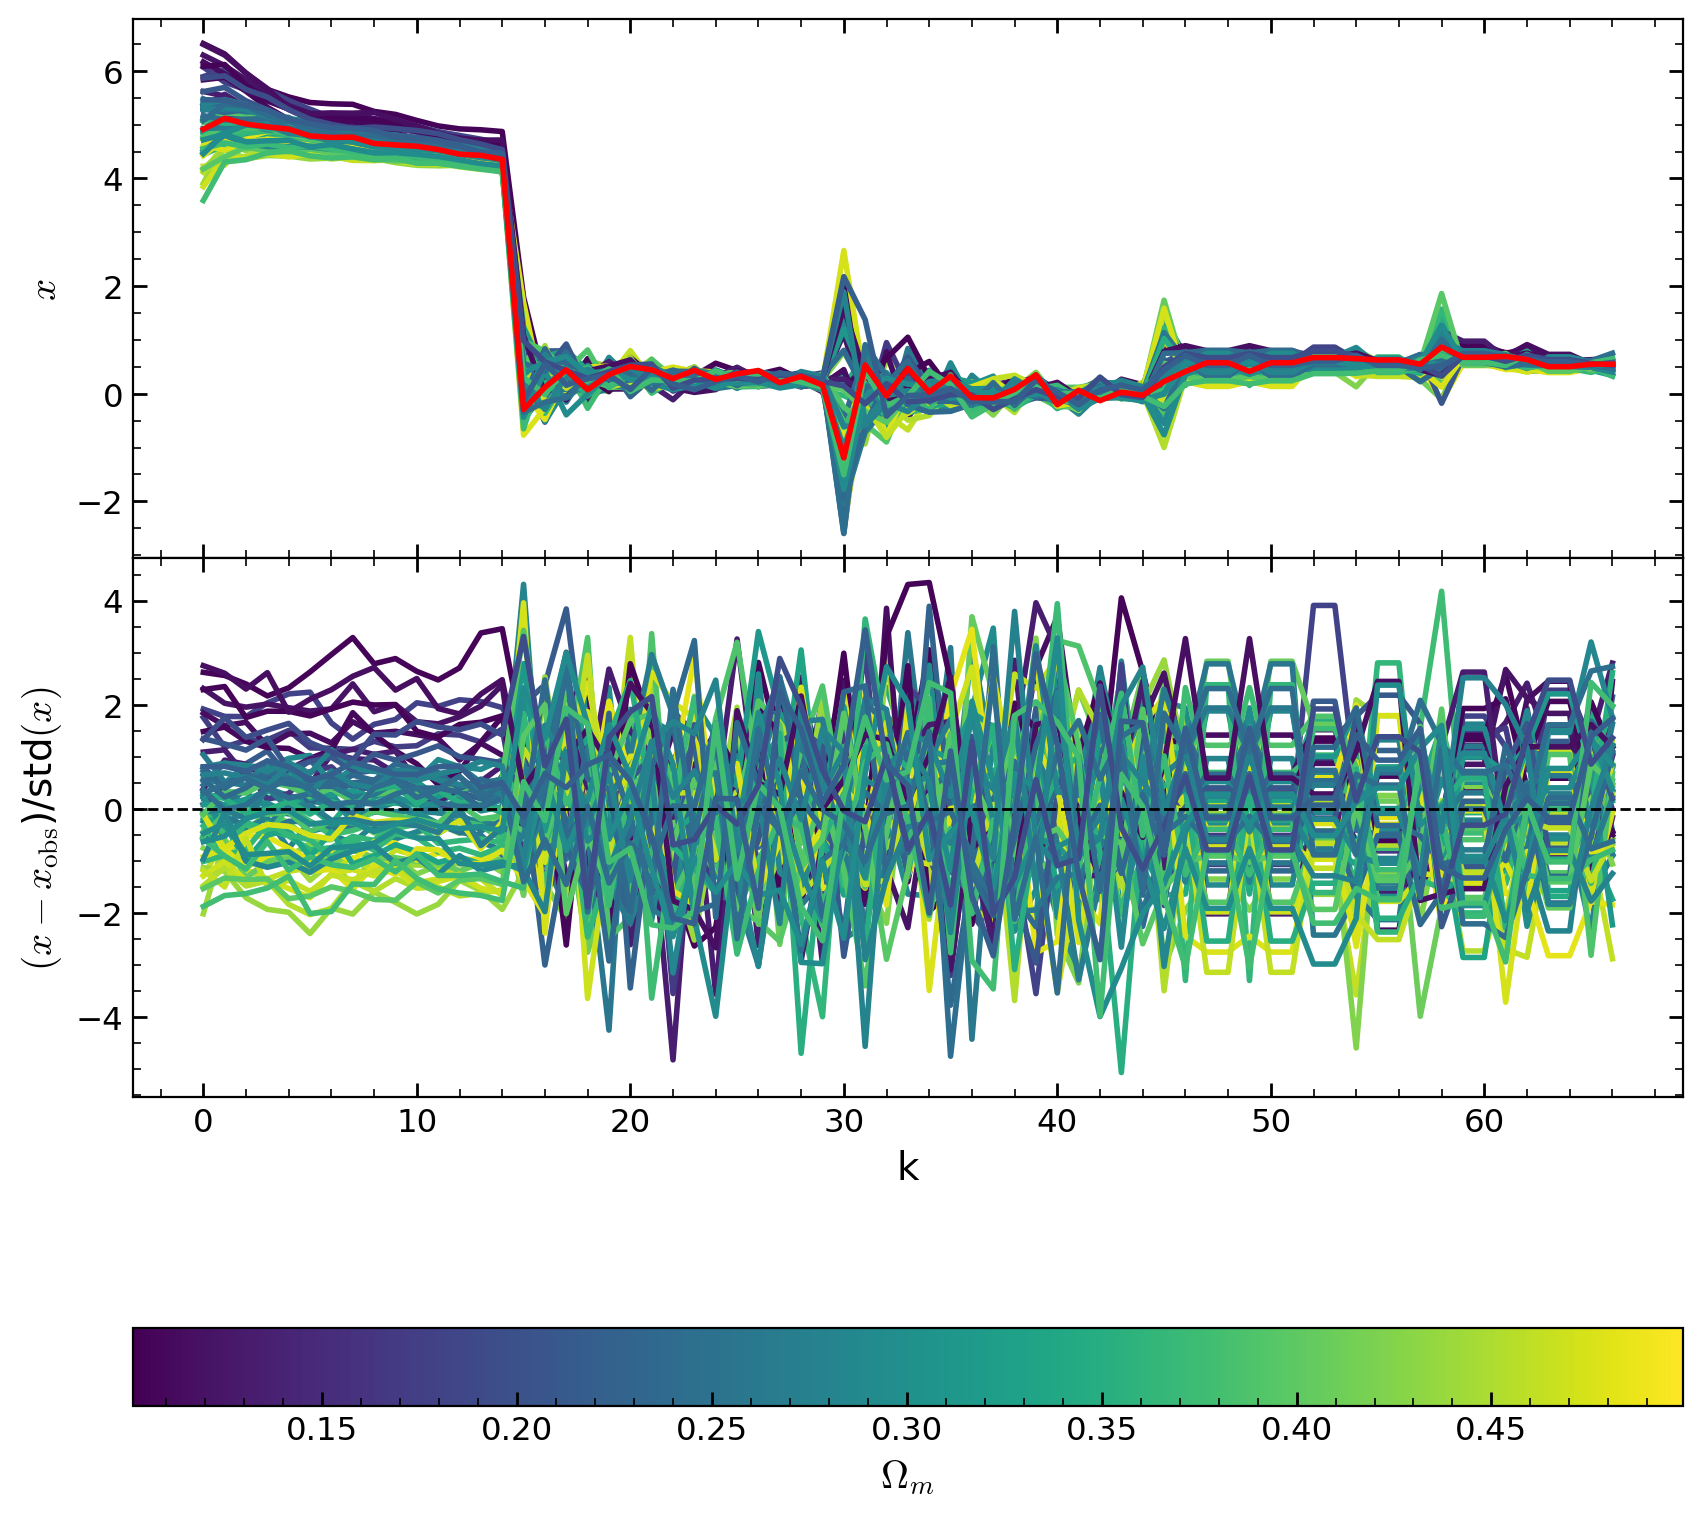

In [25]:
import matplotlib.colors as mcolors

ss = 2
ind = 30
print('ABACUS LHID:', xid[ind])

f, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True,
                      gridspec_kw=dict(hspace=0., height_ratios=[1, 1]))

par = ytest[:, 0]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

ax = axs[0]
for i in range(0, len(xobs), ss):
    ax.plot(xtest[i], color=cmap(norm(par[i])))
ax.plot(xobs[ind], 'r-', lw=2)
ax.set(ylabel=r'$x$')

ax = axs[1]
for i in range(0, len(xobs), ss):
    ax.plot((xtest[i]-xobs[i])/np.std(xtest, axis=0), color=cmap(norm(par[i])))
ax.axhline(0, c='k', ls='--', lw=1)
ax.set(xlabel='k', ylabel=r'$(x - x_{\rm obs}$)/std$(x)$')

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                  ax=axs, orientation='horizontal')
cbar.set_label(r'$\Omega_m$')

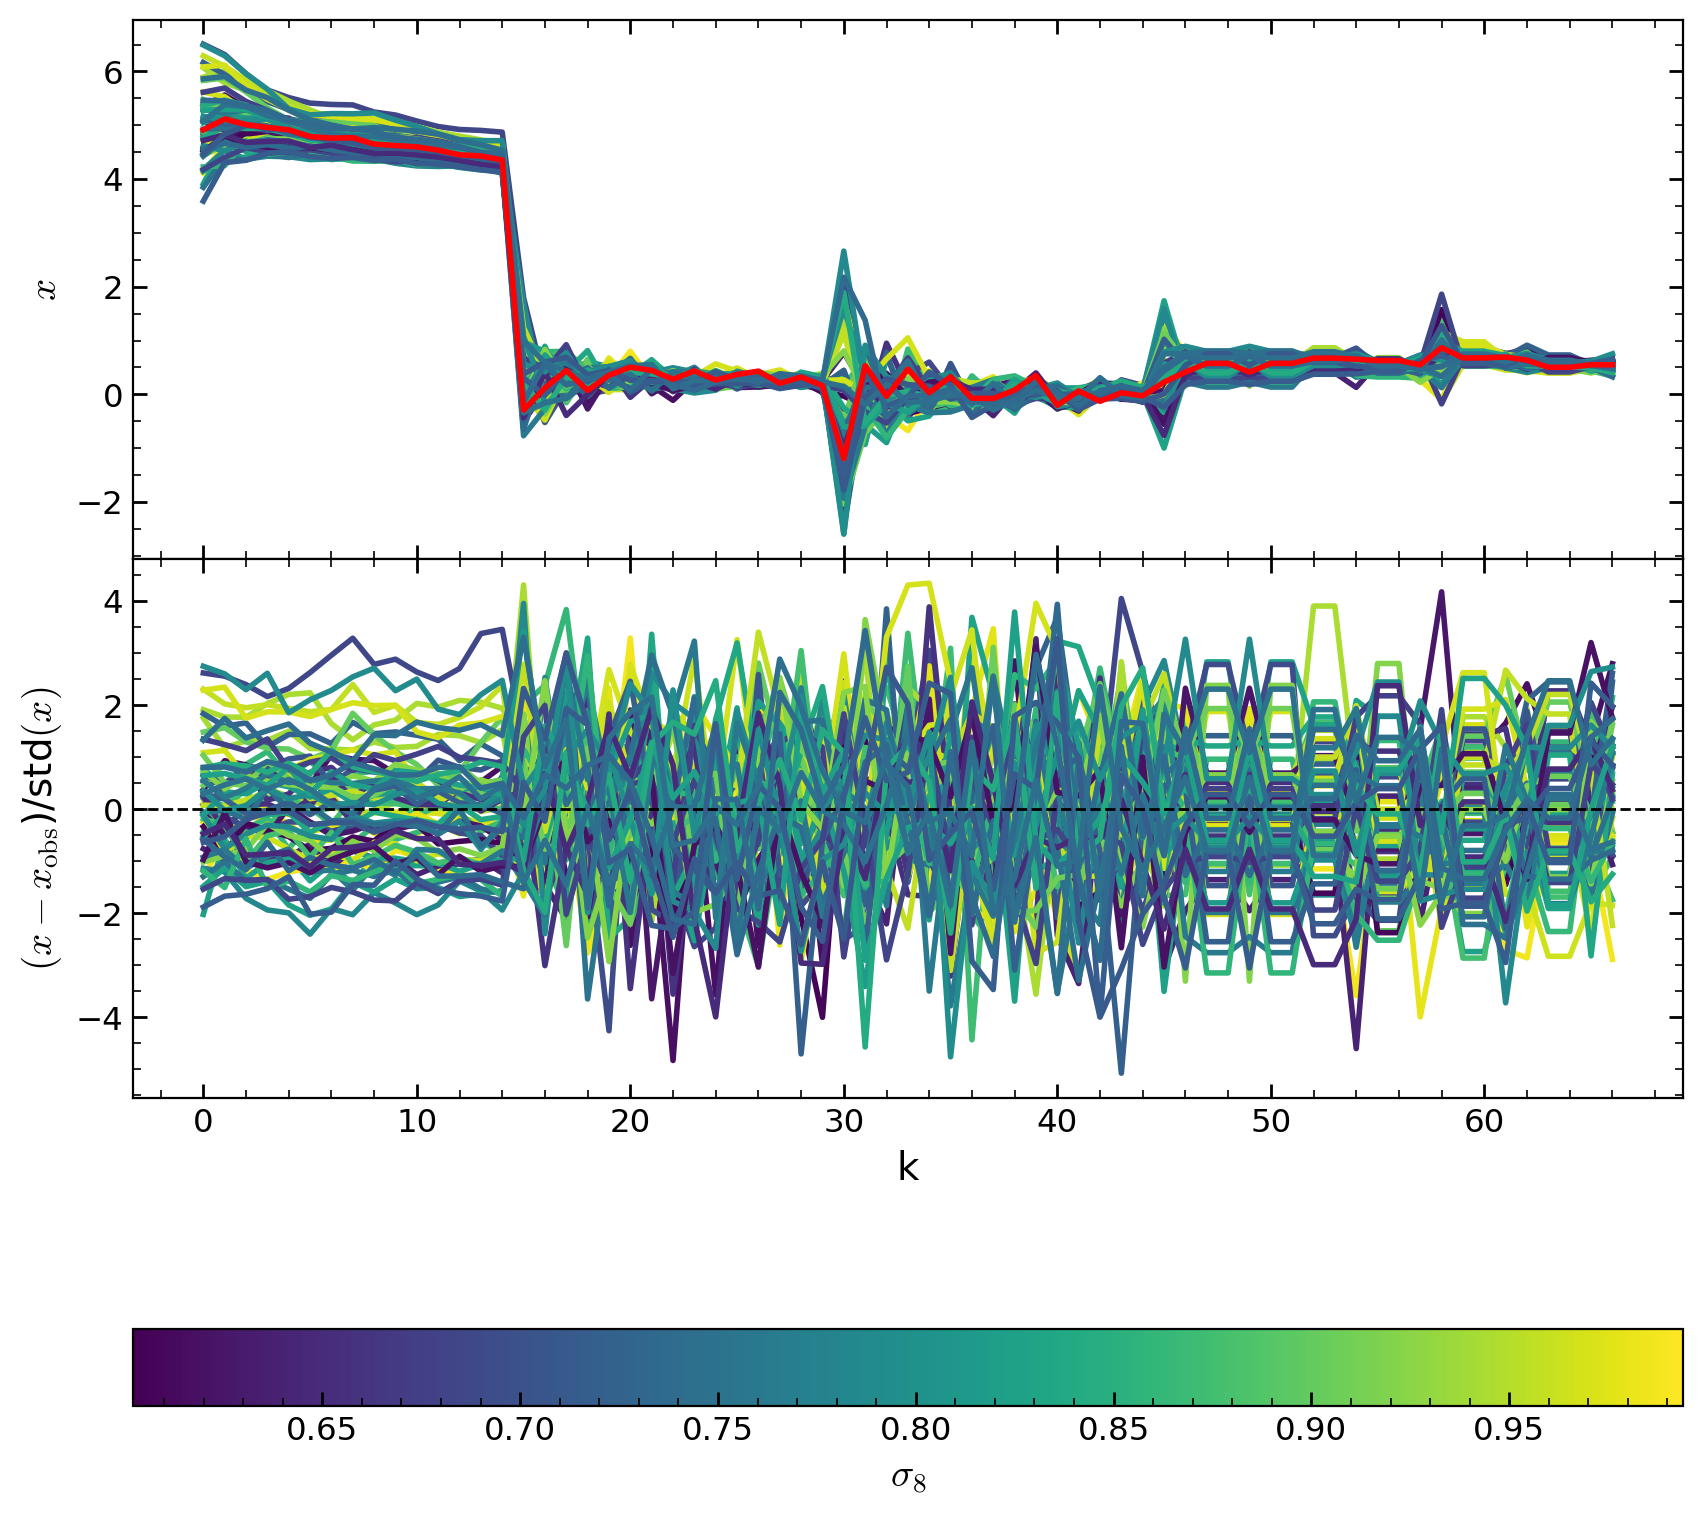

In [26]:
import matplotlib.colors as mcolors

ss = 2
ind = 30

f, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True,
                      gridspec_kw=dict(hspace=0., height_ratios=[1, 1]))

par = ytest[:, 4]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

ax = axs[0]
for i in range(0, len(xobs), ss):
    ax.plot(xtest[i], color=cmap(norm(par[i])))
ax.plot(xobs[ind], 'r-', lw=2)
ax.set(ylabel=r'$x$')

ax = axs[1]
for i in range(0, len(xobs), ss):
    ax.plot((xtest[i]-xobs[i])/np.std(xtest, axis=0), color=cmap(norm(par[i])))
ax.axhline(0, c='k', ls='--', lw=1)
ax.set(xlabel='k', ylabel=r'$(x - x_{\rm obs}$)/std$(x)$')

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                  ax=axs, orientation='horizontal')
cbar.set_label(r'$\sigma_8$')

INFO:root:Sampling models with [324, 212, 207, 194, 191, 180, 179, 177, 172, 168] samples each.
Drawing 324 posterior samples: 535it [00:00, 61358.80it/s]            
Drawing 212 posterior samples: 340it [00:00, 14927.44it/s]            
Drawing 207 posterior samples: 268it [00:00, 19615.97it/s]            
Drawing 194 posterior samples: 301it [00:00, 38544.47it/s]            
Drawing 191 posterior samples: 311it [00:00, 42184.48it/s]            
Drawing 180 posterior samples: 266it [00:00, 11340.80it/s]            
Drawing 179 posterior samples: 278it [00:00, 16677.63it/s]            
Drawing 177 posterior samples: 265it [00:00, 34134.59it/s]            
Drawing 172 posterior samples: 279it [00:00, 36800.24it/s]            
Drawing 168 posterior samples: 298it [00:00, 16923.05it/s]            


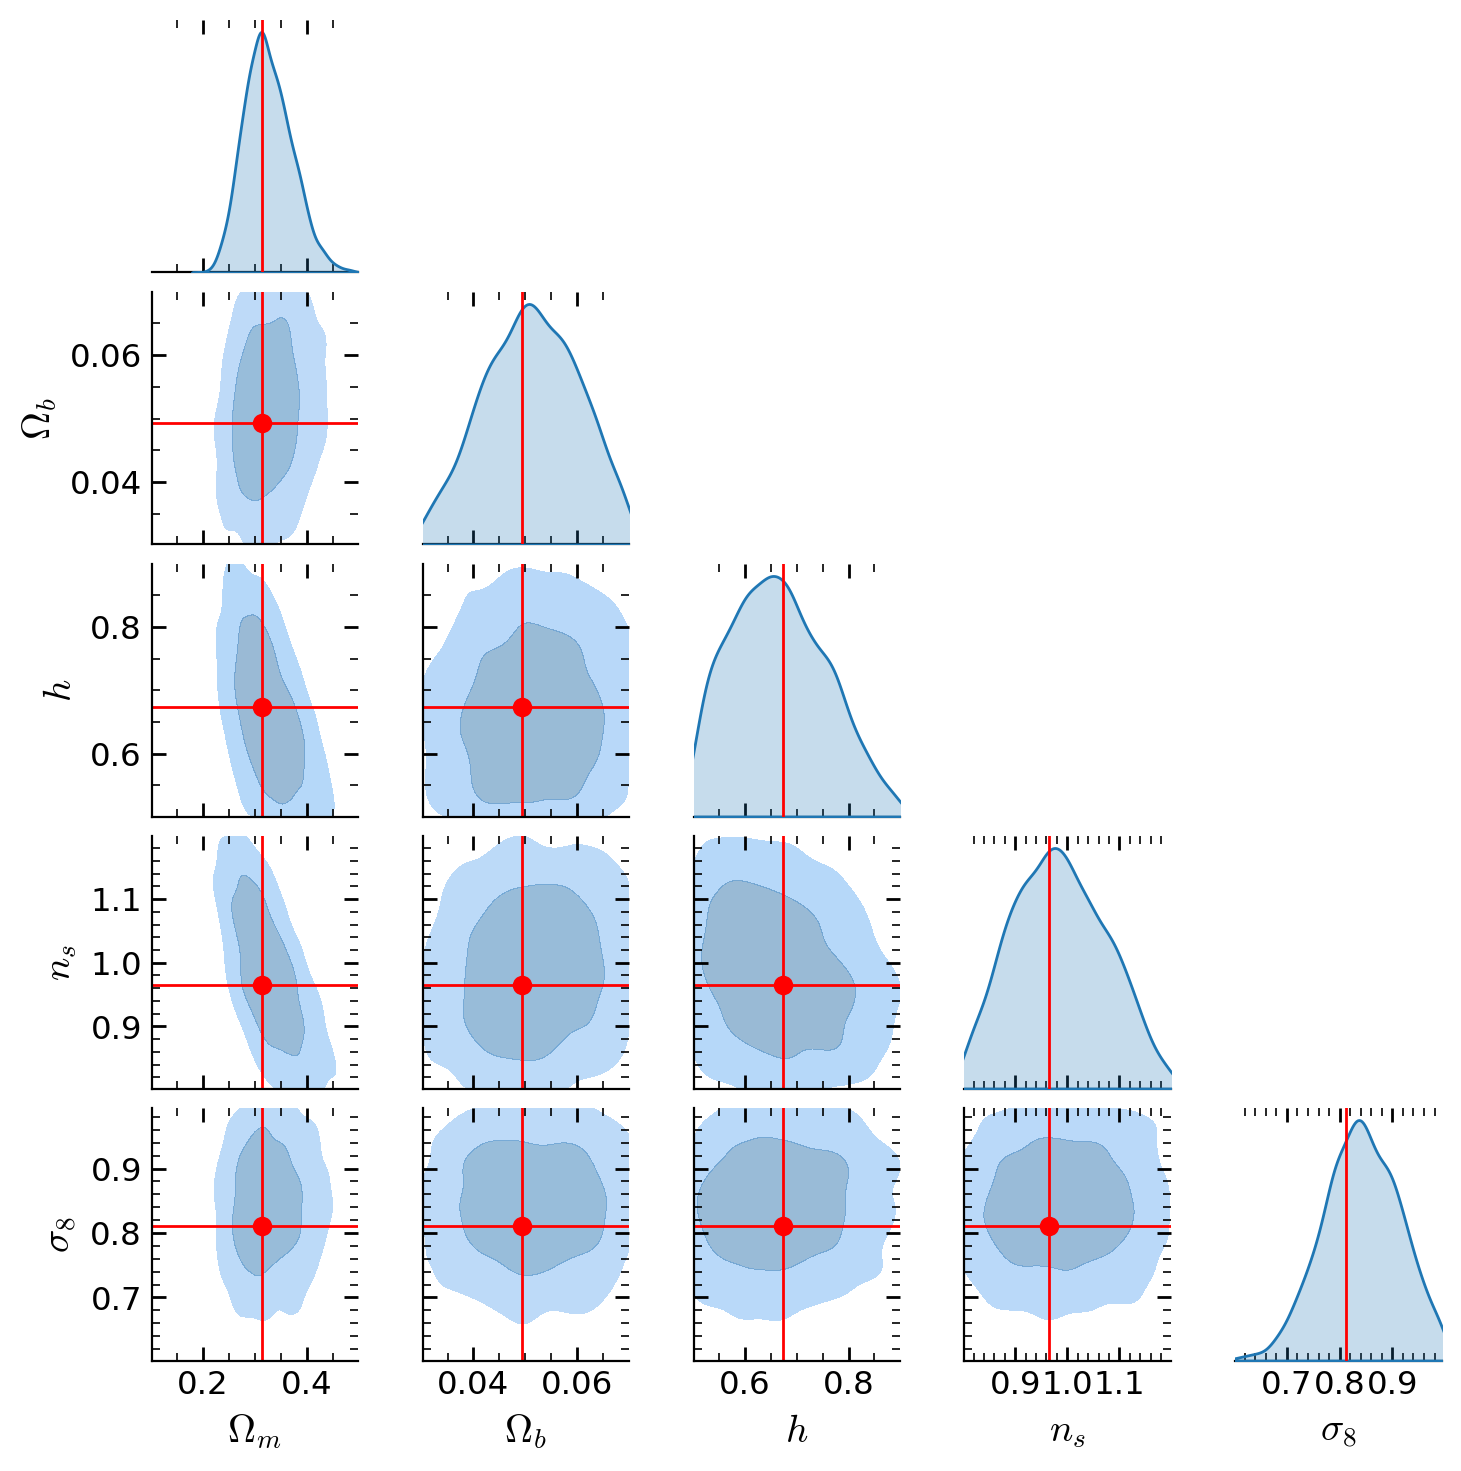

In [27]:
# Predict on a random test point
ind = 30
samp0 = posterior.sample(x=xobs[ind], shape=(1999,)).to('cpu')
samp0 = pd.DataFrame(samp0, columns=names)


def plot_true_vals(grid, true_vals, **kwargs):
    for i, val in enumerate(true_vals):
        grid.diag_axes[i].axvline(val, **kwargs)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.axvline(true_vals[j], **kwargs)
                ax.axhline(val, **kwargs)
                ax.plot(true_vals[j], val, 'o', **kwargs)


def set_boundaries(grid, prior_range):
    for i, (x, y) in enumerate(prior_range):
        grid.diag_axes[i].set_xlim(x, y)
        for j, ax in enumerate(grid.axes[i, :i]):
            if ax:
                ax.set_ylim(x, y)
                ax.set_xlim(*prior_range[j])


g = sns.pairplot(
    samp0,
    vars=names,
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)

plot_true_vals(g, yobs[ind], color='r', lw=1)
set_boundaries(g, yrange)

## Predict on a suite of summaries

In [28]:
samps = []
for xin in tqdm(xobs):
    samp = posterior.sample(x=xin, shape=(
        1000,), show_progress_bars=False).to('cpu')
    samps.append(samp)
samps = np.array(samps)
trues = np.array(yobs)

100%|██████████| 119/119 [00:34<00:00,  3.41it/s]


In [29]:
def _get_first(arr):
    mask = np.isin(np.arange(len(arr)), np.sort(
        np.unique(arr, return_index=True)[1]))
    return mask


# get only the first occurrence of each unique value
first = _get_first(xid)

# LCDM w/ Mnu>0
flag1 = 'LCDM, w/ Mnu>0'
m1 = np.isin(xid, idx_lcdm) & np.isin(xid, idx_mnu) & first
# LCDM w/ Mnu=0
flag2 = 'LCDM, w/ Mnu=0'
m2 = np.isin(xid, idx_lcdm) & ~np.isin(xid, idx_mnu) & first
# No cuts
flag3 = ''
m3 = np.ones(len(xid), dtype=bool) & first

ms = [m1, m2, m3]
flags = [flag1, flag2, flag3]
m, flag = m3, flag3

Text(0.5, 0.98, 'zPk0+zPk2+zPk4+zQk0, $k\\in[0.0,0.1]$, w/o prior correction')

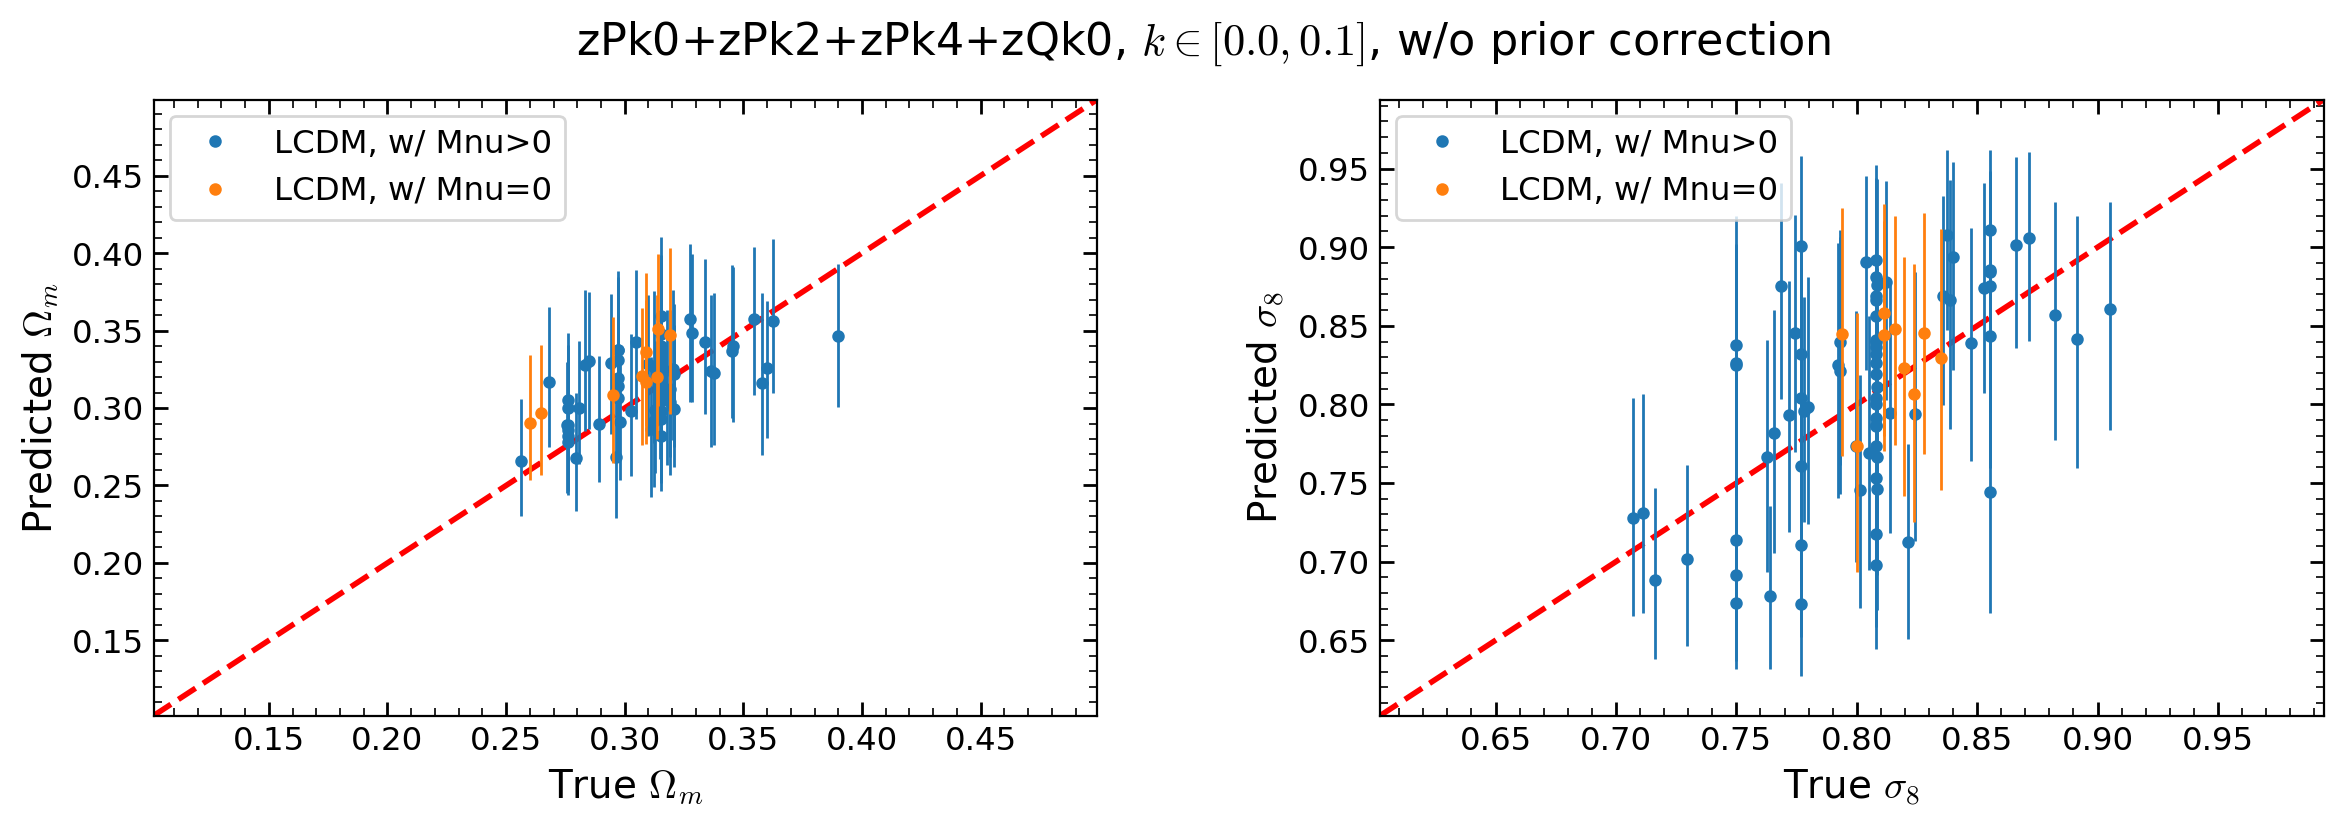

In [30]:
H, W = 1, 2
f, axs = plt.subplots(H, W, figsize=(7*W, 4*H), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()


for j, i in enumerate([0, 4]):
    ax = axs[j]
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.set_xlim(yrange[i])
    ax.set_ylim(yrange[i])
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')
    for k, m in enumerate(ms[:2]):
        percs = np.percentile(samps[m, :, i], [50, 16, 84], axis=1)
        ax.plot(trues[m, i], percs[0], '.',
                color=f'C{k}', markersize=7, label=flags[k])
        ax.errorbar(trues[m, i], percs[0], yerr=[percs[0]-percs[1],
                    percs[2]-percs[0]], fmt='none', color=f'C{k}', elinewidth=1)
    ax.legend()

f.suptitle(
    '+'.join(summaries) + f', $k\in[{kmin},{kmax}]$,'
    ' w/o prior correction',
    fontsize=16)

Text(0.5, 0.98, 'zPk0+zPk2+zPk4+zQk0, kmin-0.0_kmax-0.1, w/o prior correction, ')

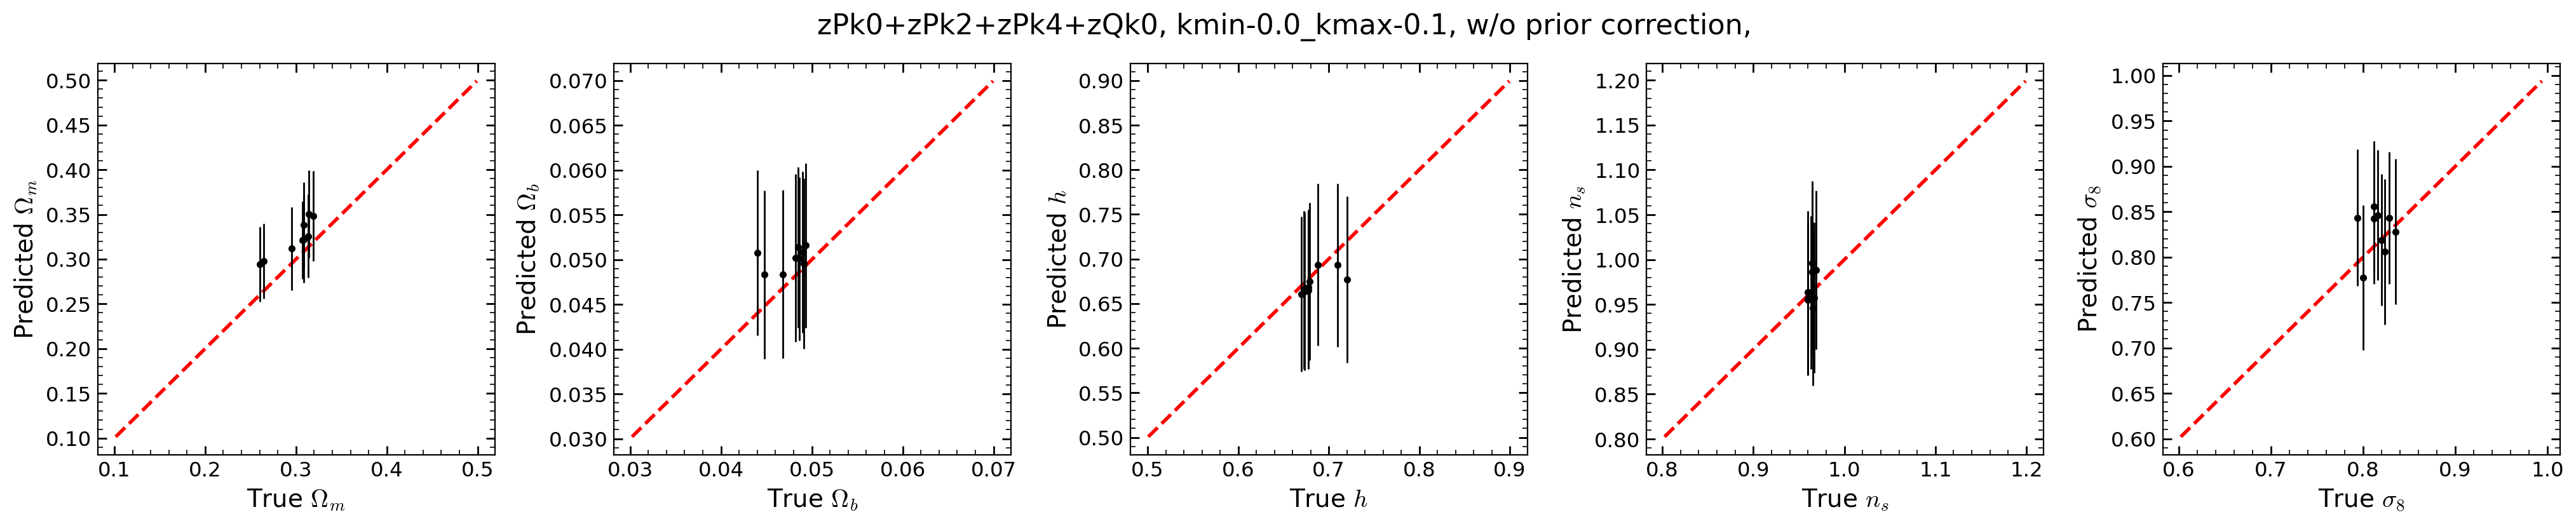

In [31]:
Nparams = trues.shape[-1]

H, W = Nparams//5, 5
f, axs = plt.subplots(H, W, figsize=(W*5, H*4), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()
for i in range(Nparams):
    means = np.average(samps[m, :, i], axis=1)
    stds = np.sqrt(np.average((samps[m, :, i] - means[:, None])**2, axis=1))
    axs[i].plot(yrange[i], yrange[i], 'r--')
    axs[i].plot(trues[m, i], means, 'k.')
    axs[i].errorbar(trues[m, i], means, yerr=stds,
                    fmt='none', ecolor='k', elinewidth=1)
    axs[i].set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')
f.suptitle(
    '+'.join(summaries) + f', kmin-{kmin}_kmax-{kmax},'
    ' w/o prior correction, ' + flag,
    fontsize=16)

Text(0.5, 0.98, 'Pk0+Pk2+Pk4+Qk0 With Abacus prior correction')

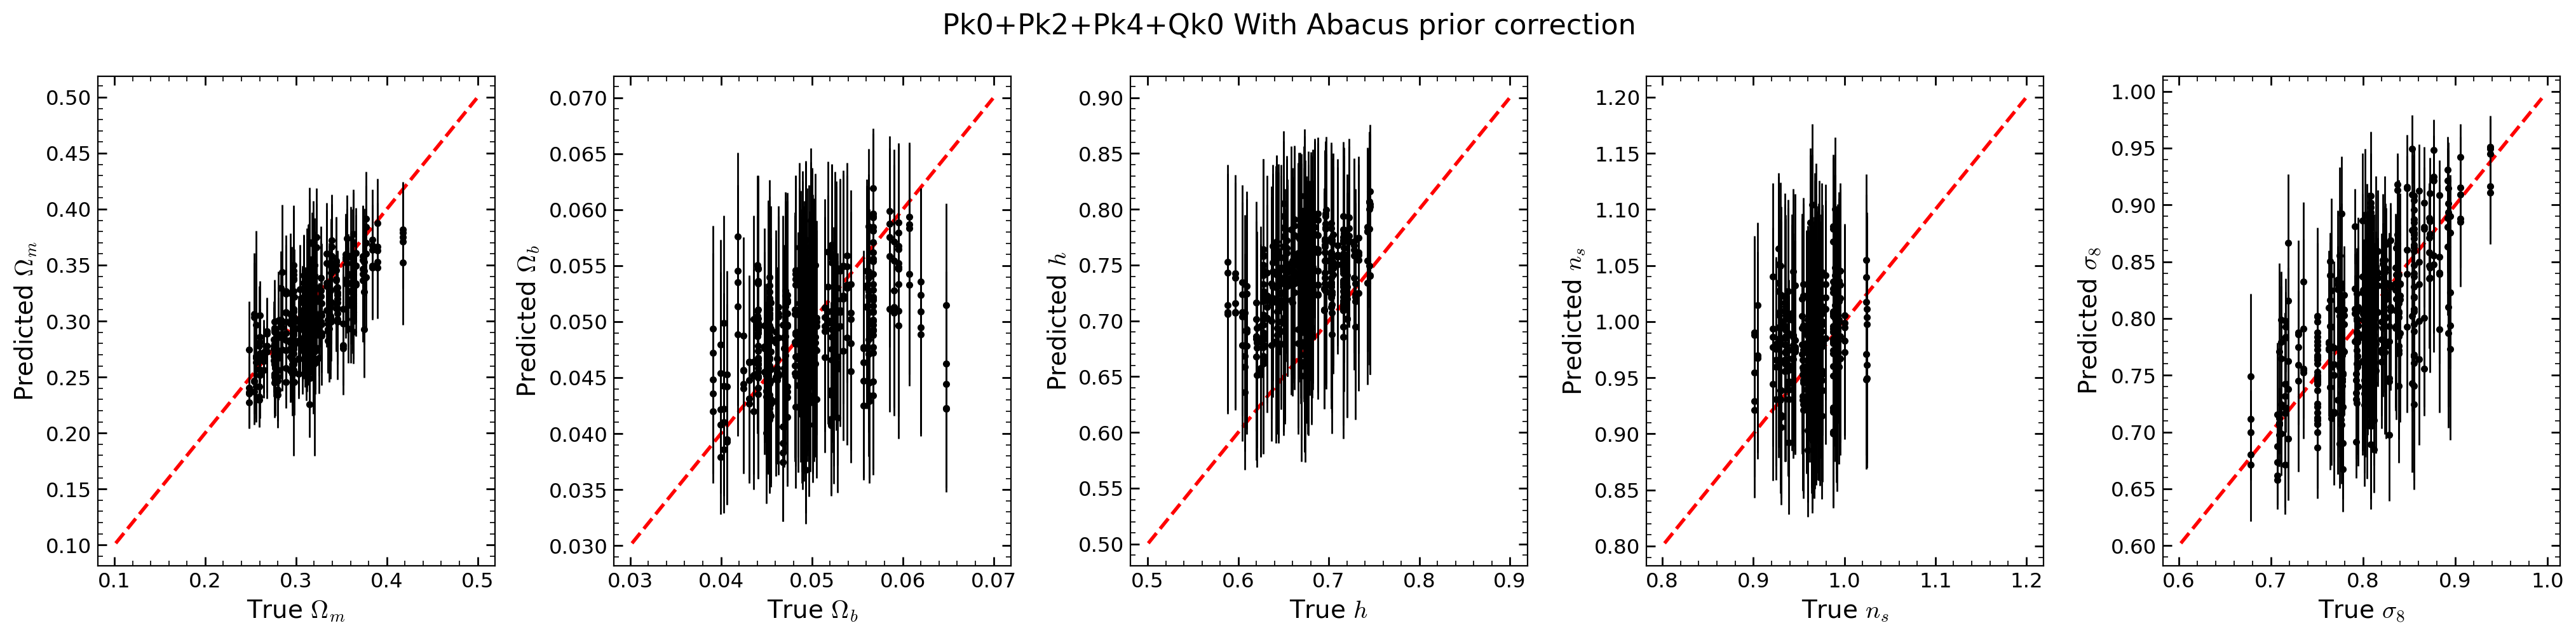

In [82]:
# normalize weights
weights = samps[:, :, 2]**4
weights /= weights.sum(axis=1)[:, None]

Nparams = trues.shape[-1]

H, W = Nparams//5, 5
f, axs = plt.subplots(H, W, figsize=(W*5, H*5), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()
for i in range(Nparams):
    means = np.average(samps[:, :, i], axis=1, weights=weights)
    stds = np.sqrt(np.average(
        (samps[:, :, i] - means[:, None])**2, axis=1, weights=weights))
    axs[i].plot(yrange[i], yrange[i], 'r--')
    axs[i].plot(trues[:, i], means, 'k.')
    axs[i].errorbar(trues[:, i], means, yerr=stds,
                    fmt='none', ecolor='k', elinewidth=1)
    axs[i].set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')
f.suptitle('+'.join(summaries)+' With Abacus prior correction', fontsize=16)